In [1]:
import os
import random
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
MODEL_NAME = "gray_to_rgb_model.pth"
MODEL_PATH = os.path.join("..", "models", MODEL_NAME)

BASE_DIR = os.path.join("..", "data", "coco")
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

In [3]:
IMG_SIZE = 64
EPOCHS = 30
BATCH_SIZE = 128
CONV1_OUT_CHANNELS = 64
CONV2_OUT_CHANNELS = 128
CONV3_OUT_CHANNELS = 256
FC1_DIM = 32
FC2_DIM = 16
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5

In [4]:
SEED_VALUE = 42
random.seed(SEED_VALUE)
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)
torch.cuda.manual_seed_all(SEED_VALUE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class IMGDataset(torch.utils.data.Dataset):
    def __init__(self, folder):
        self.files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('.jpg', '.png'))])

        gray_transforms_list = [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.Grayscale(num_output_channels=1)
        ]

        if folder.endswith("train"):
            gray_transforms_list += [
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.1, contrast=0.1)
            ]

        gray_transforms_list += [
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ]

        self.gray_transform = transforms.Compose(gray_transforms_list)

        self.color_transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        gray = self.gray_transform(img)
        original = self.color_transform(img)
        return gray, original

In [7]:
train_dataset = IMGDataset(TRAIN_DIR)
val_dataset = IMGDataset(VAL_DIR)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True)

In [8]:
class Encoder(nn.Module):
    def __init__(self, conv1_channel, conv2_channel, conv3_channel, fc1_dim, fc2_dim):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, conv1_channel, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(conv1_channel),
            nn.ReLU(),
            nn.Conv2d(conv1_channel, conv2_channel, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(conv2_channel),
            nn.ReLU(),
            nn.Conv2d(conv2_channel, conv2_channel, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(conv2_channel),
            nn.ReLU(),
            nn.Conv2d(conv2_channel, conv3_channel, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(conv3_channel),
            nn.ReLU()
        )

        self.flattened_size = self.get_flattened_size()

        self.fc_block = nn.Sequential(
            nn.Linear(self.flattened_size, fc1_dim),
            nn.ELU(),
            nn.Linear(fc1_dim, fc2_dim)
        )

    def get_flattened_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, IMG_SIZE, IMG_SIZE)
            output = self.conv_block(dummy_input)
            return output.view(output.shape[0], -1).shape[1]


    def get_conv_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, IMG_SIZE, IMG_SIZE)
            output = list(self.conv_block(dummy_input).shape)
            return output
    
    def forward(self, x):
        out = self.conv_block(x)
        out = out.view(out.shape[0], -1)
        out = self.fc_block(out)
        return out

In [9]:
class Decoder(nn.Module):
    def __init__(self, conv_size, conv1_channel, conv2_channel, conv3_channel, fc1_dim, fc2_dim):
        super().__init__()
        self.conv_size = conv_size
        self.flatten_conv_size = np.prod(self.conv_size[1:])
        self.fc_block = nn.Sequential(
            nn.Linear(fc2_dim, fc1_dim),
            nn.ELU(),
            nn.Linear(fc1_dim, self.flatten_conv_size),
            nn.ELU()
        )

        self.conv_block = nn.Sequential(
            nn.ConvTranspose2d(conv3_channel, conv2_channel, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(conv2_channel, conv2_channel, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(conv2_channel, conv1_channel, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(conv1_channel, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = self.fc_block(x)
        out = out.view(batch_size, *self.conv_size[1:])
        out = self.conv_block(out)
        return out

In [10]:
def train_model(
    device,
    model,
    optimizer, loss_fn,
    train_loader):
    
    model.train()
    total_loss = 0.0
    train_loop = tqdm(train_loader, desc="Training")
    for x, y in train_loop:
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss

        train_loop.set_postfix(loss=loss.item())

    return total_loss

In [11]:
def evaluate_model(
    device,
    model,
    loss_fn,
    val_loader):
    
    model.eval()
    total_loss = 0.0
    val_loop = tqdm(val_loader, desc="Validation")
    with torch.no_grad():
        for x, y in val_loop:
            x, y = x.to(device), y.to(device)
            output = model(x)

            loss = loss_fn(output, y)
            total_loss += loss

            val_loop.set_postfix(loss=loss.item())

    return total_loss

In [12]:
def show_gray_vs_rgb(gray_batch, rgb_batch, n=5):
    gray_batch = gray_batch.cpu()
    rgb_batch = rgb_batch.cpu()
    
    plt.figure(figsize=(n*3, 6))
    
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(gray_batch[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.ylabel("Gray", fontsize=12)
        
        plt.subplot(2, n, i+n+1)
        img = rgb_batch[i].permute(1, 2, 0)
        img = (img * 0.5 + 0.5).clamp(0,1)
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.ylabel("RGB", fontsize=12)

    plt.show()

In [13]:
encoder = Encoder(CONV1_OUT_CHANNELS, CONV2_OUT_CHANNELS, CONV3_OUT_CHANNELS, FC1_DIM, FC2_DIM)
conv_size = encoder.get_conv_size()
decoder = Decoder(conv_size, CONV1_OUT_CHANNELS, CONV2_OUT_CHANNELS, CONV3_OUT_CHANNELS, FC1_DIM, FC2_DIM)

model = nn.Sequential(
    encoder,
    decoder
).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

loss_fn = nn.MSELoss()

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.87it/s, loss=0.127]

Epoch: 1
	train_loss: 0.1253
	val_loss: 0.1085

Model saved with val loss 0.1085.


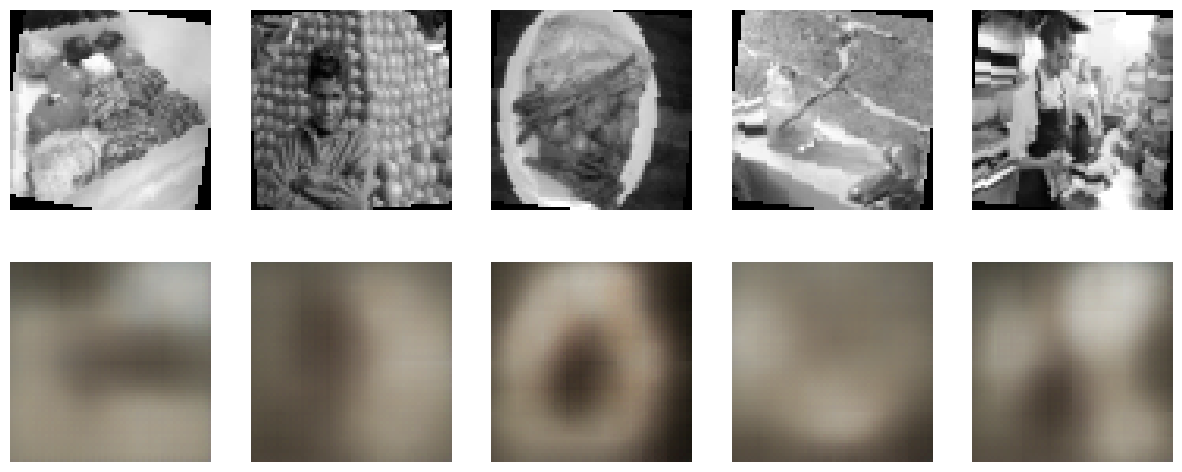

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.91it/s, loss=0.123]

Epoch: 2
	train_loss: 0.1080
	val_loss: 0.1032

Model saved with val loss 0.1032.


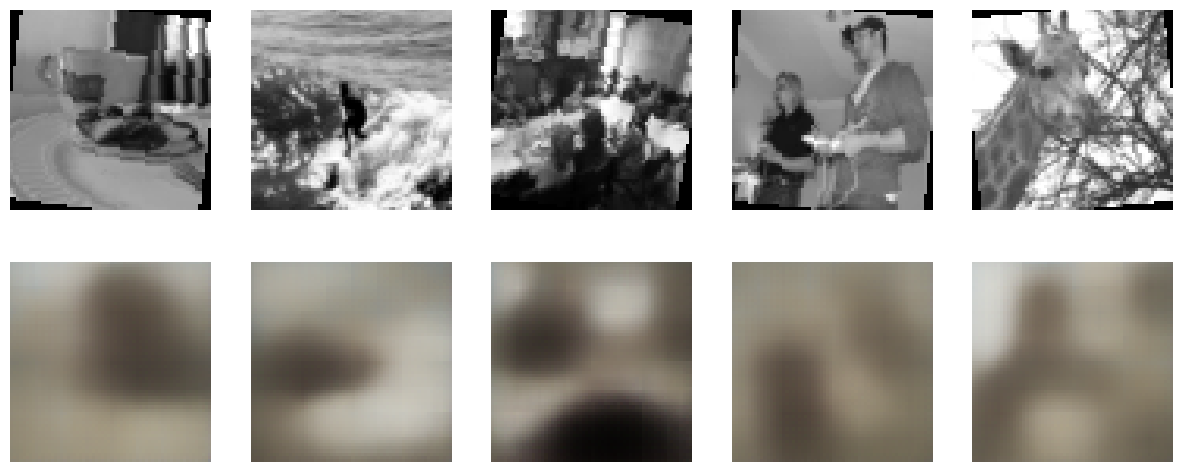

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.84it/s, loss=0.125]

Epoch: 3
	train_loss: 0.1062
	val_loss: 0.1045



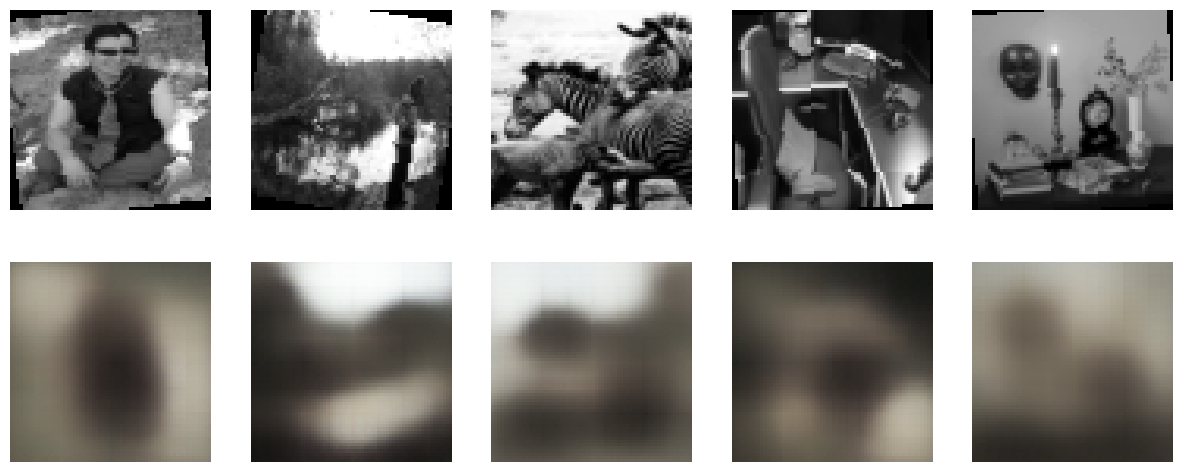

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.90it/s, loss=0.127]

Epoch: 4
	train_loss: 0.1054
	val_loss: 0.1032



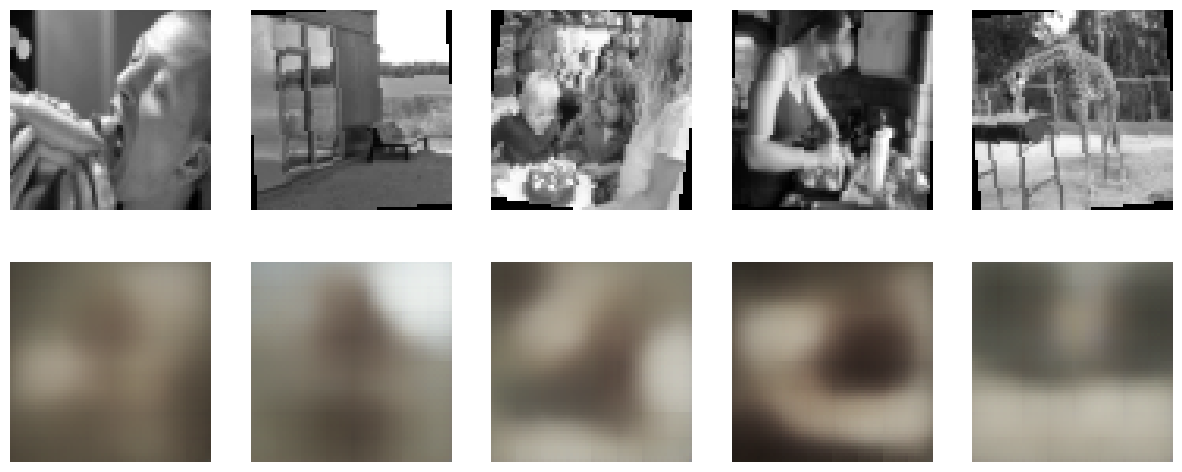

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.05it/s, loss=0.126]

Epoch: 5
	train_loss: 0.1033
	val_loss: 0.1039



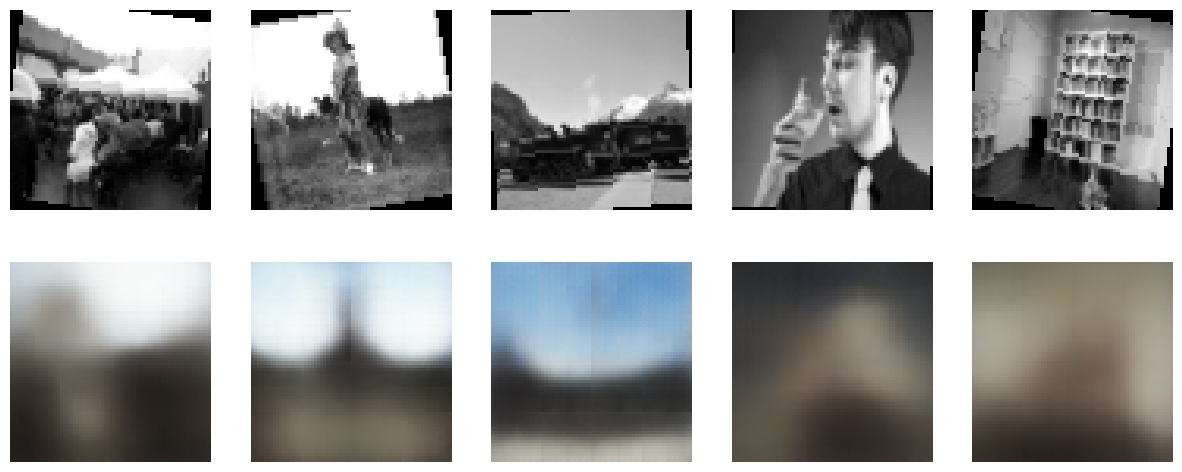

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.01it/s, loss=0.122]

Epoch: 6
	train_loss: 0.1029
	val_loss: 0.1013

Model saved with val loss 0.1013.


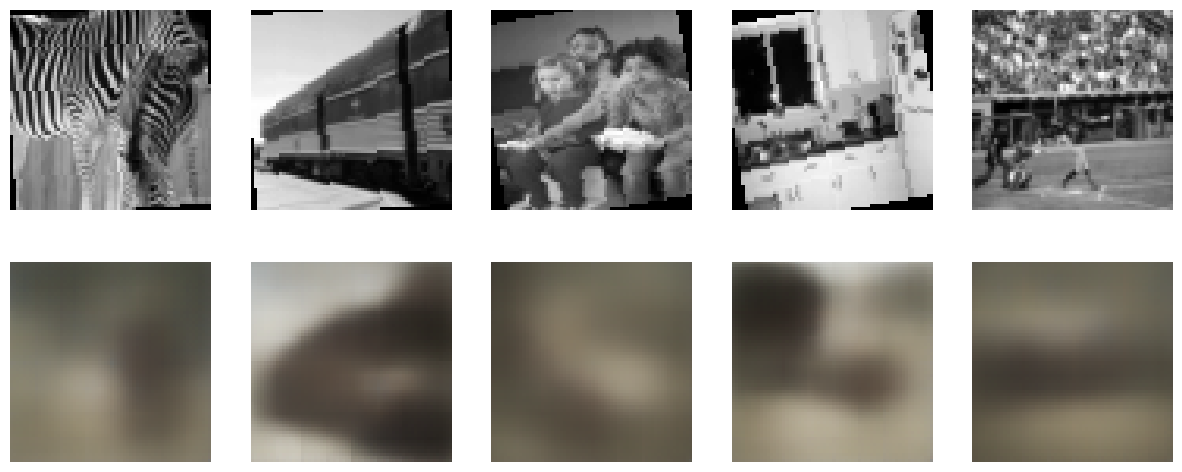

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.04it/s, loss=0.123]

Epoch: 7
	train_loss: 0.1024
	val_loss: 0.1025



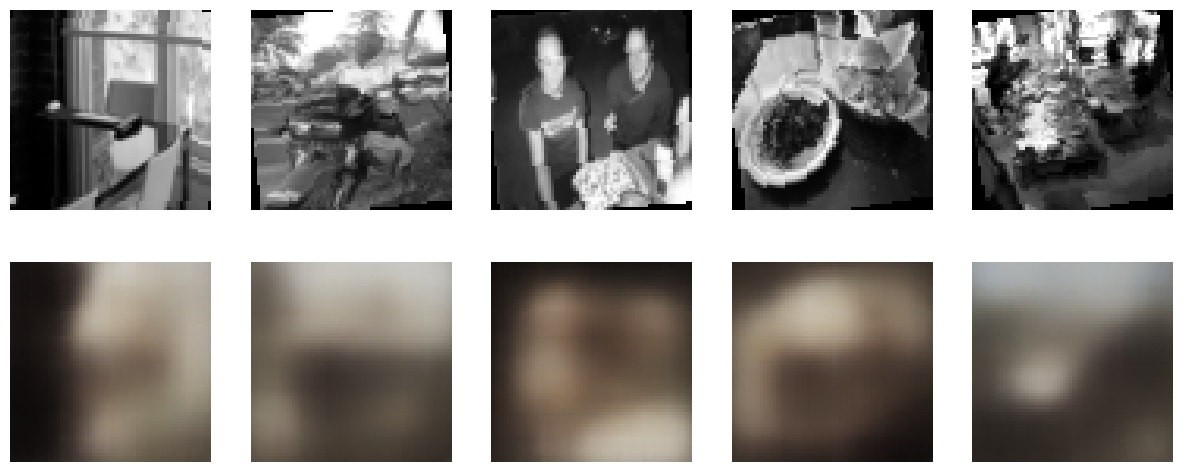

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.05it/s, loss=0.121]

Epoch: 8
	train_loss: 0.1021
	val_loss: 0.1022



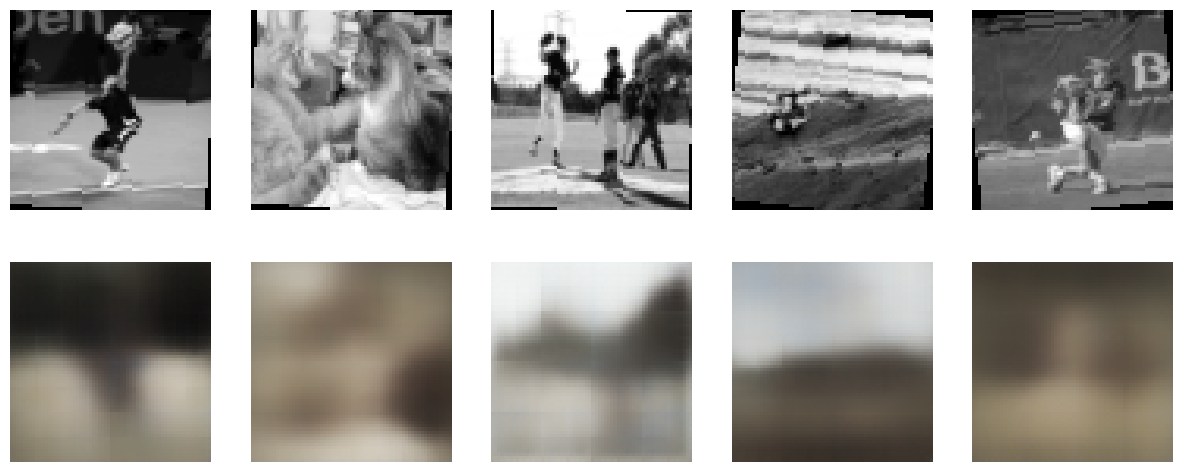

Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.03it/s, loss=0.12]

Epoch: 9
	train_loss: 0.1011
	val_loss: 0.0999

Model saved with val loss 0.0999.


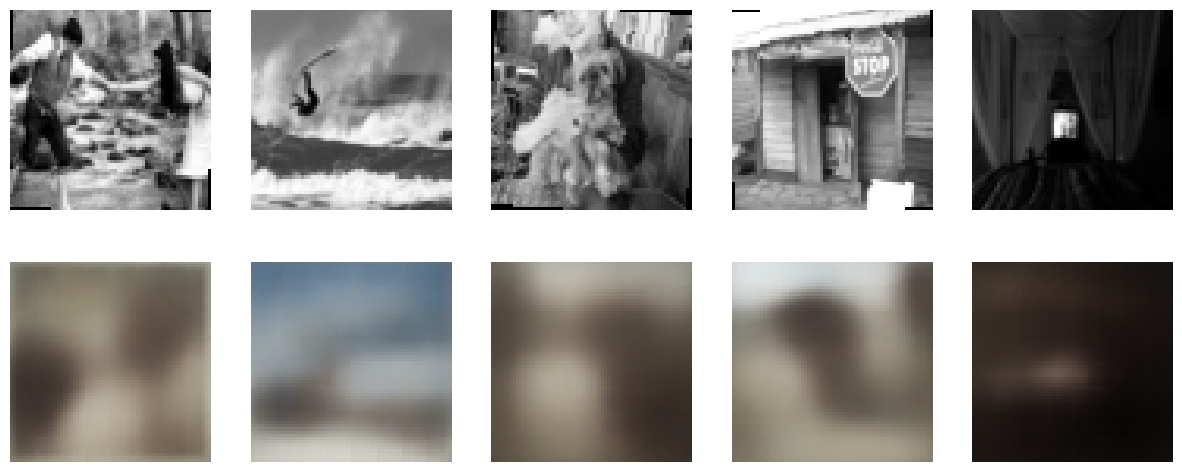

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.81it/s, loss=0.121]

Epoch: 10
	train_loss: 0.1009
	val_loss: 0.0997

Model saved with val loss 0.0997.


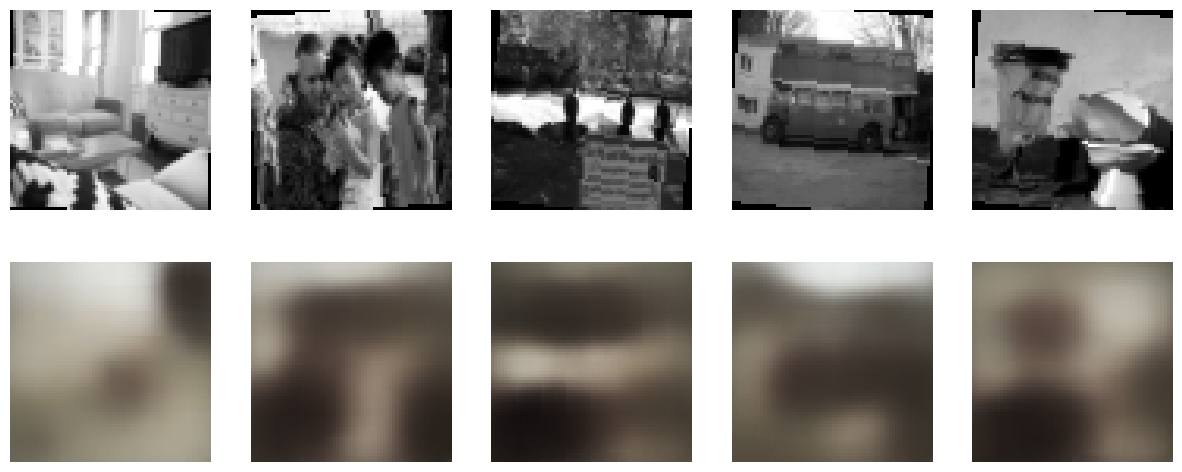

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.90it/s, loss=0.121]

Epoch: 11
	train_loss: 0.1007
	val_loss: 0.0996

Model saved with val loss 0.0996.


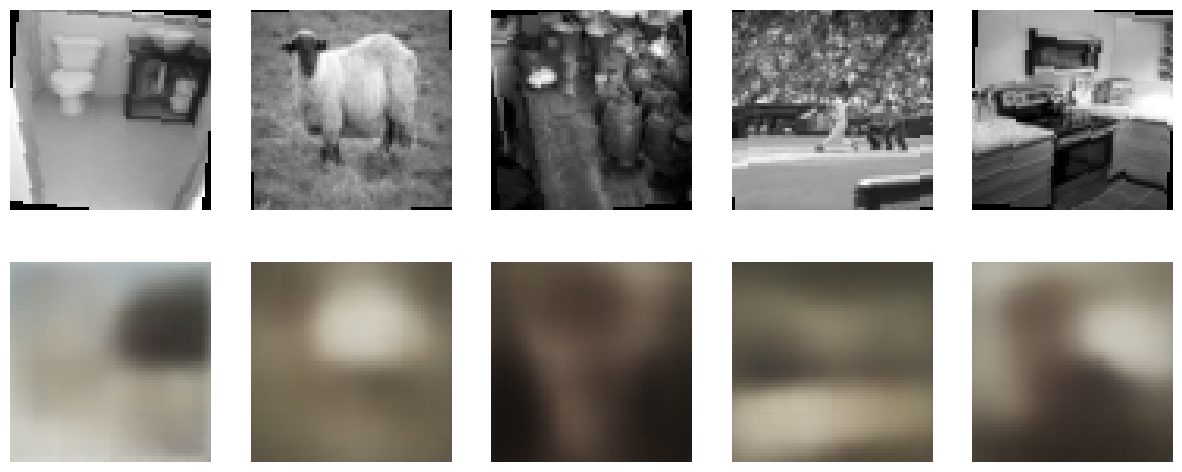

Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.87it/s, loss=0.12]

Epoch: 12
	train_loss: 0.1006
	val_loss: 0.0998



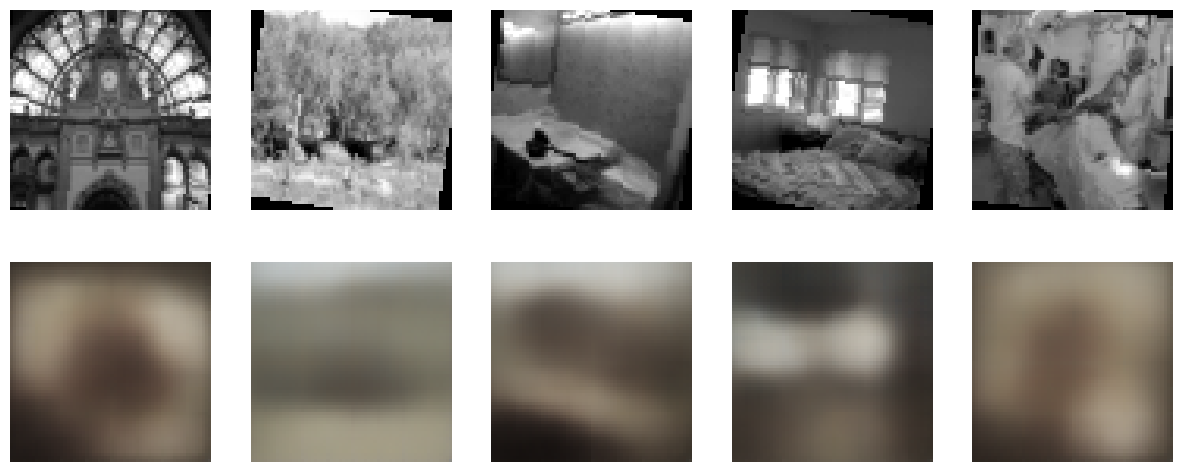

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.80it/s, loss=0.119]

Epoch: 13
	train_loss: 0.1005
	val_loss: 0.0995

Model saved with val loss 0.0995.


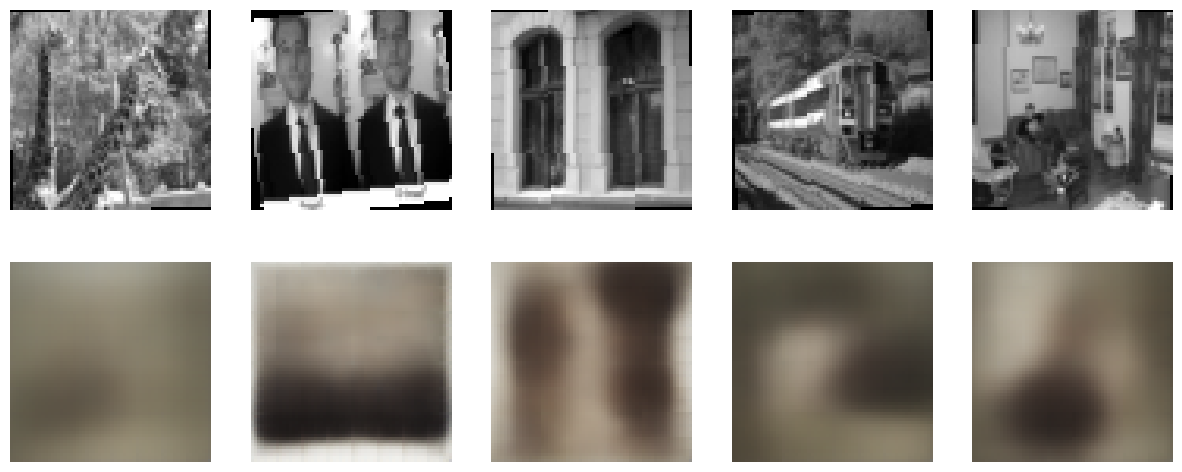

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.87it/s, loss=0.119]

Epoch: 14
	train_loss: 0.1004
	val_loss: 0.0993

Model saved with val loss 0.0993.


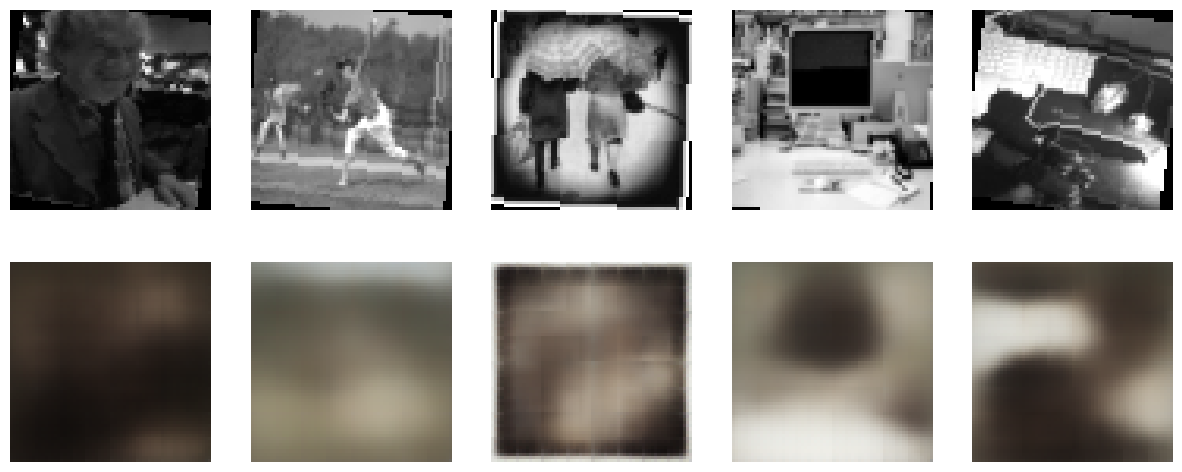

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.82it/s, loss=0.118]

Epoch: 15
	train_loss: 0.1003
	val_loss: 0.0996



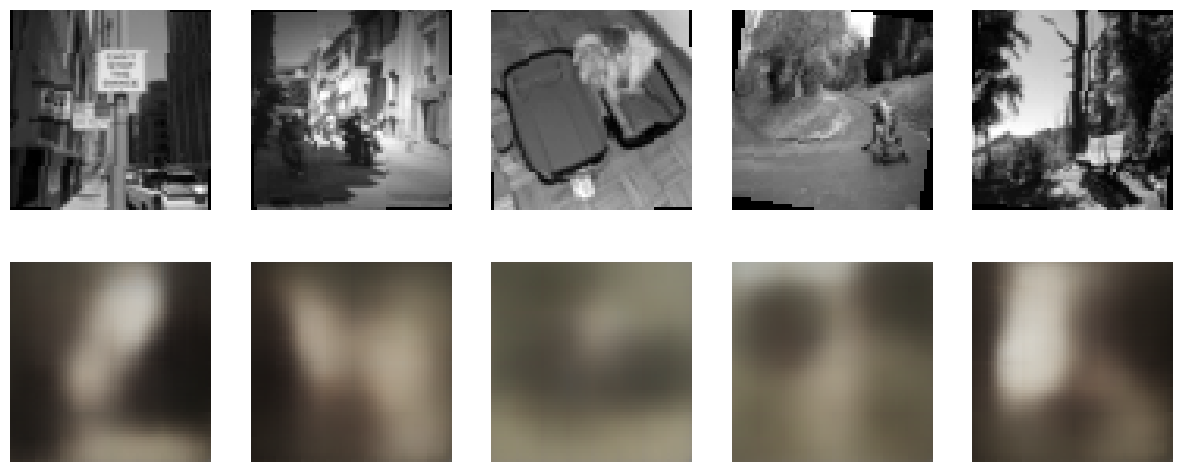

Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.83it/s, loss=0.12]

Epoch: 16
	train_loss: 0.1002
	val_loss: 0.1001



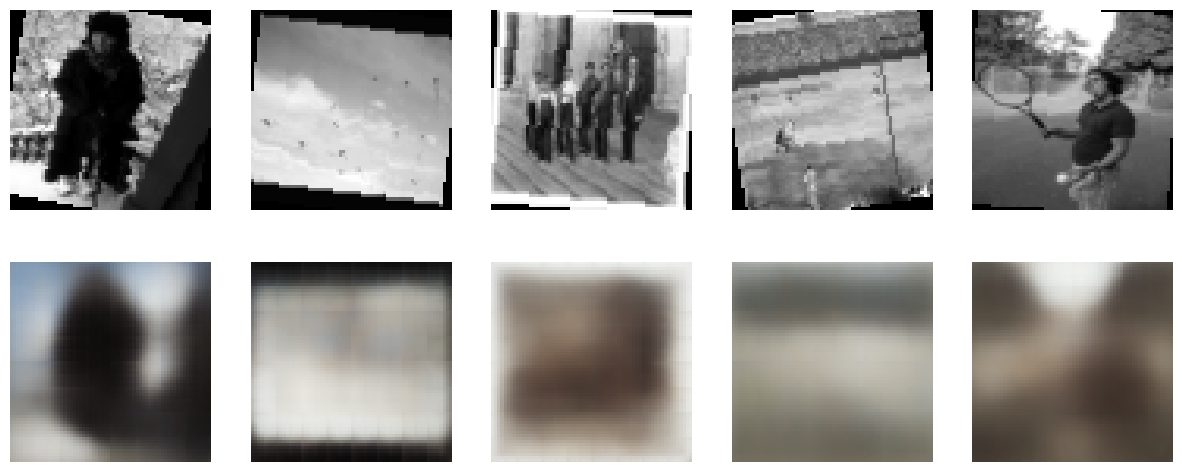

Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.80it/s, loss=0.12]

Epoch: 17
	train_loss: 0.0996
	val_loss: 0.0991

Model saved with val loss 0.0991.


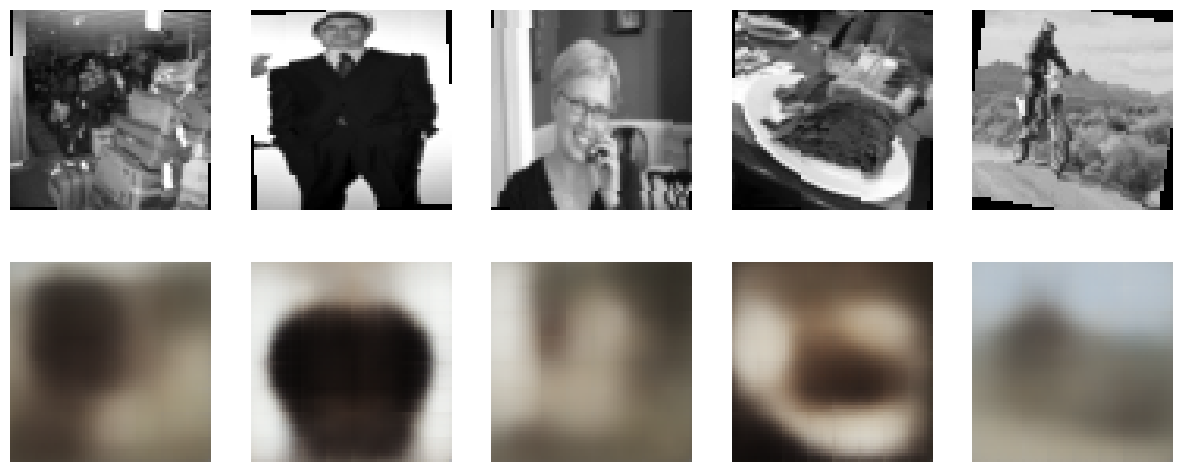

Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.86it/s, loss=0.12]

Epoch: 18
	train_loss: 0.0995
	val_loss: 0.0991



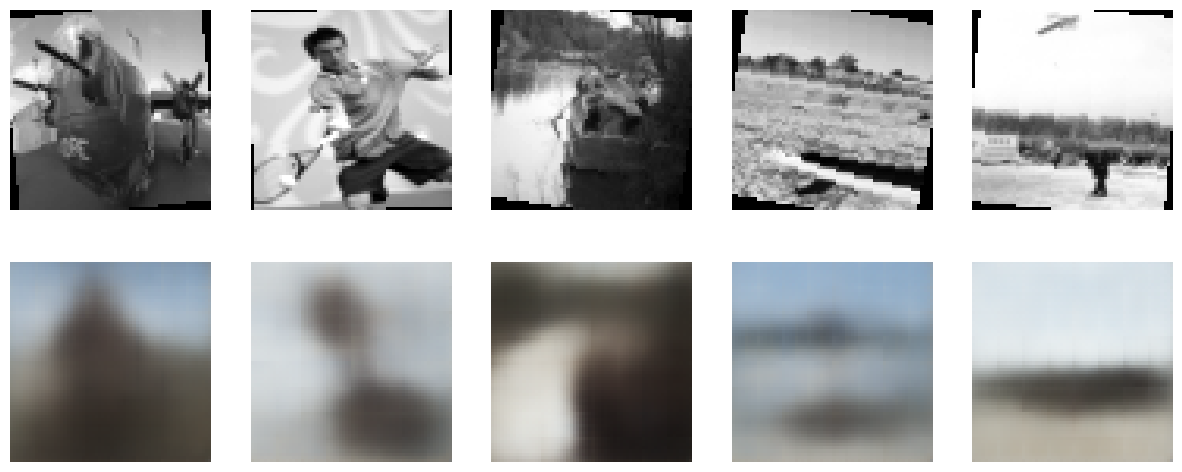

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.83it/s, loss=0.121]

Epoch: 19
	train_loss: 0.0994
	val_loss: 0.0991



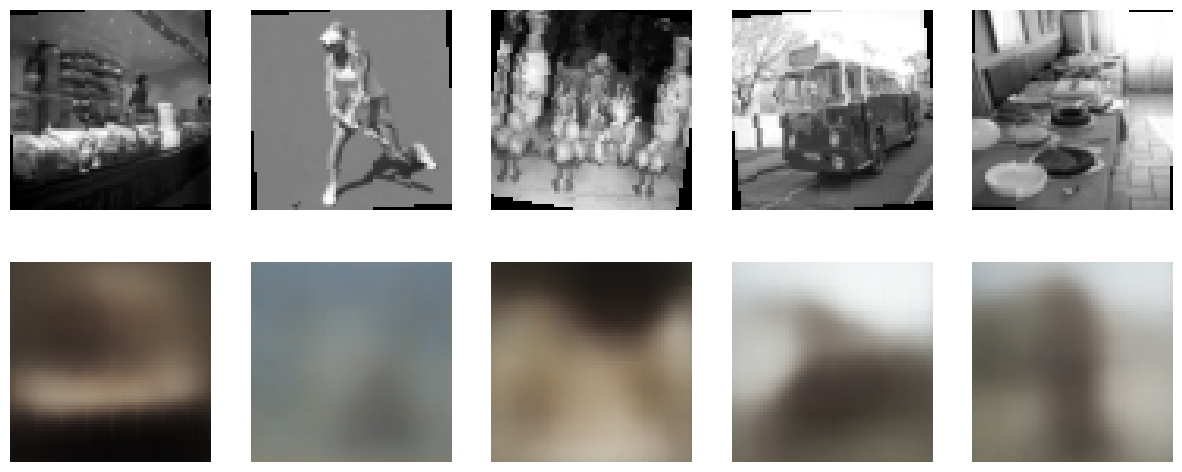

Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.95it/s, loss=0.12]

Epoch: 20
	train_loss: 0.0991
	val_loss: 0.0988

Model saved with val loss 0.0988.


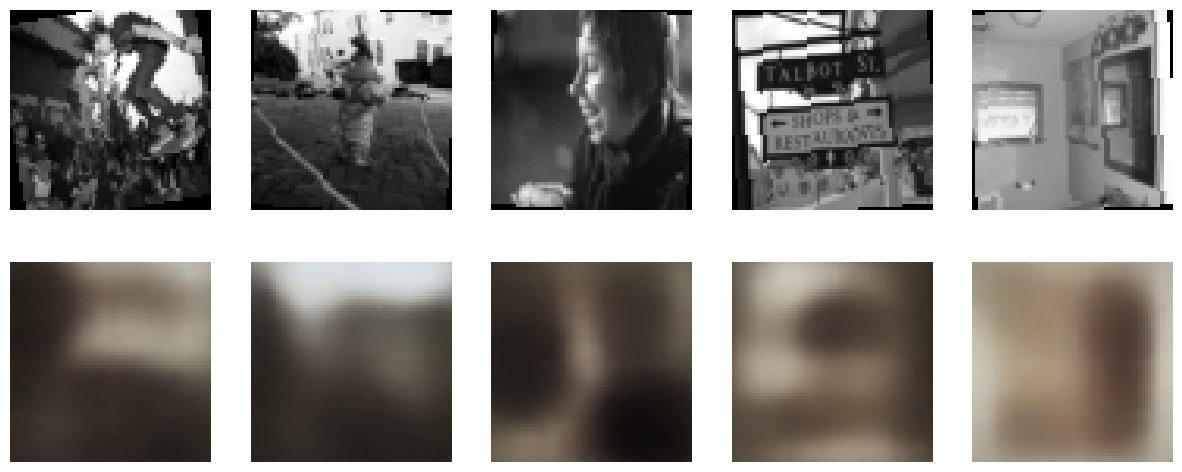

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.94it/s, loss=0.119]

Epoch: 21
	train_loss: 0.0990
	val_loss: 0.0985

Model saved with val loss 0.0985.


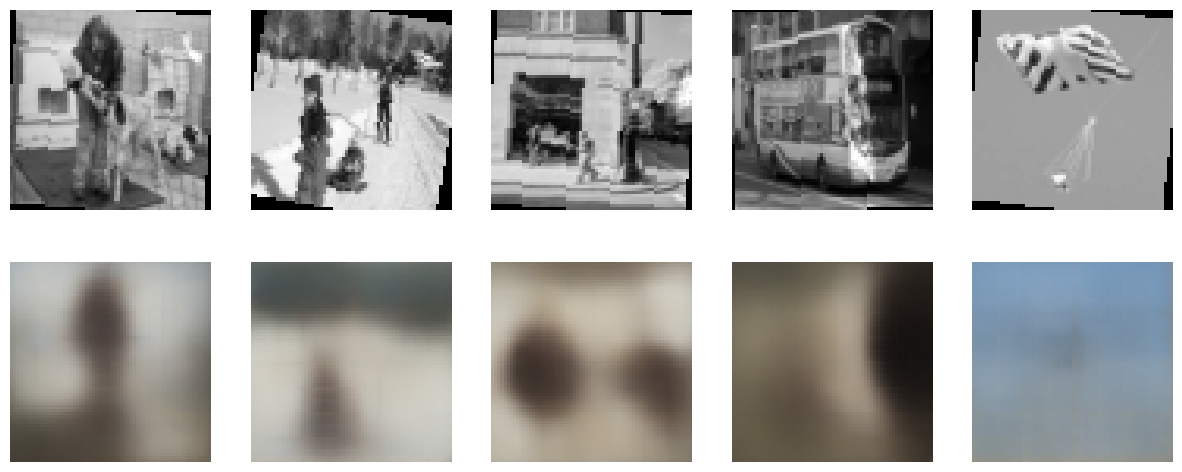

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.86it/s, loss=0.118]

Epoch: 22
	train_loss: 0.0989
	val_loss: 0.0986



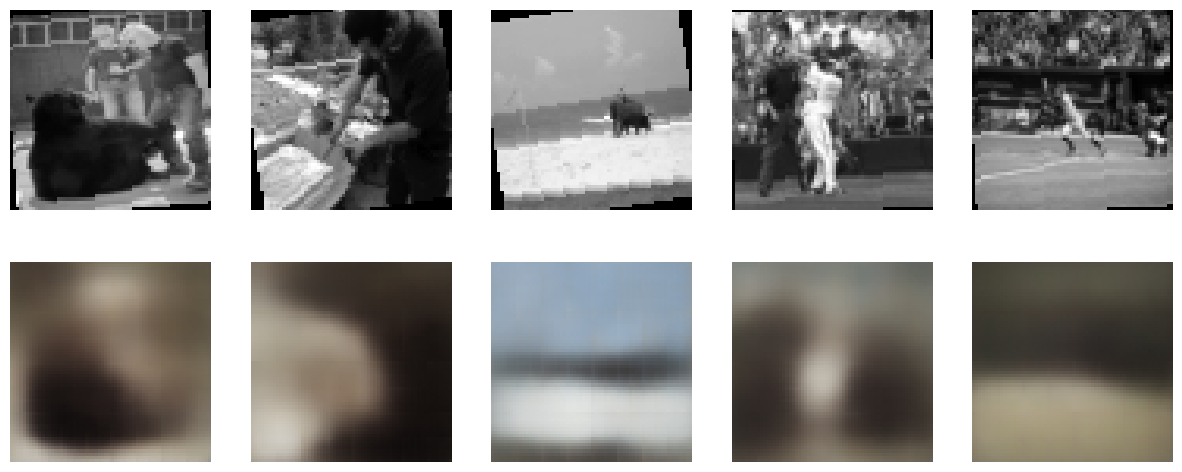

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.86it/s, loss=0.118]

Epoch: 23
	train_loss: 0.0989
	val_loss: 0.0986



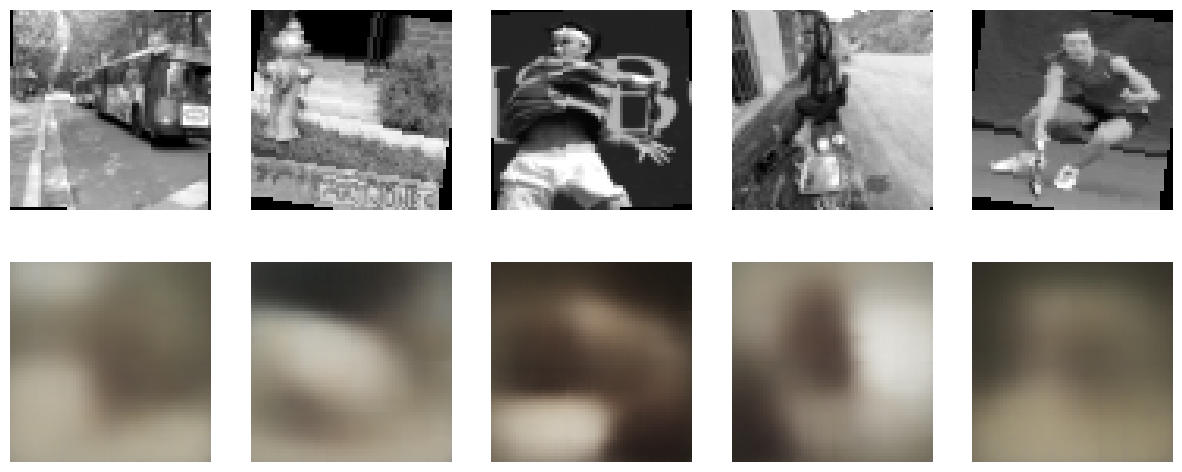

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.09it/s, loss=0.118]

Epoch: 24
	train_loss: 0.0987
	val_loss: 0.0985



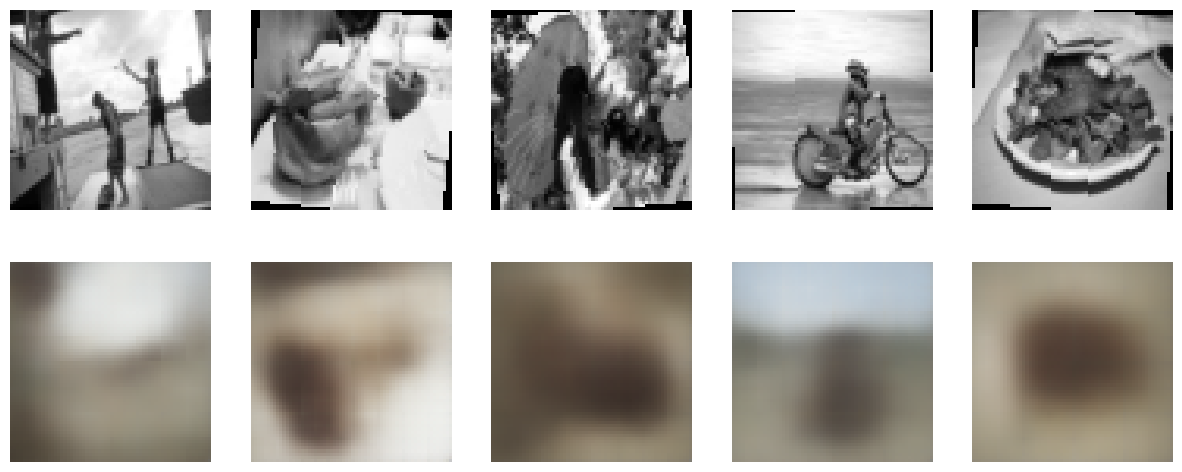

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.02it/s, loss=0.117]

Epoch: 25
	train_loss: 0.0986
	val_loss: 0.0984

Model saved with val loss 0.0984.


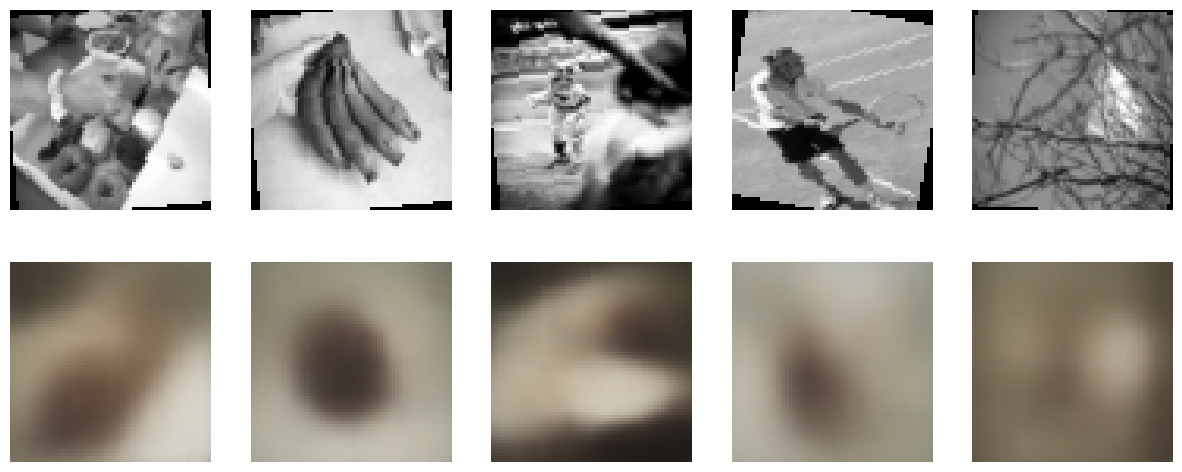

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.02it/s, loss=0.119]

Epoch: 26
	train_loss: 0.0986
	val_loss: 0.0984

Model saved with val loss 0.0984.


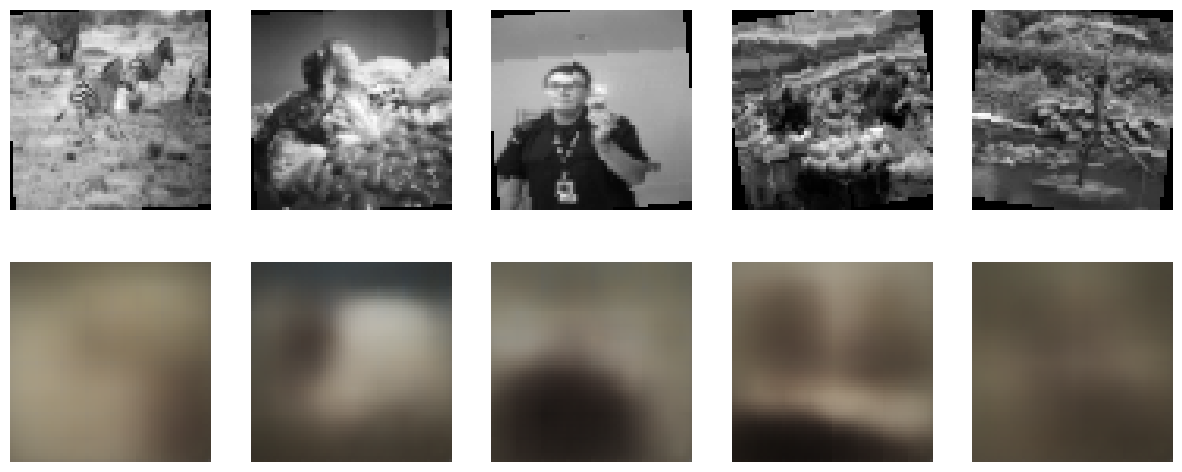

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.03it/s, loss=0.118]

Epoch: 27
	train_loss: 0.0986
	val_loss: 0.0984

Model saved with val loss 0.0984.


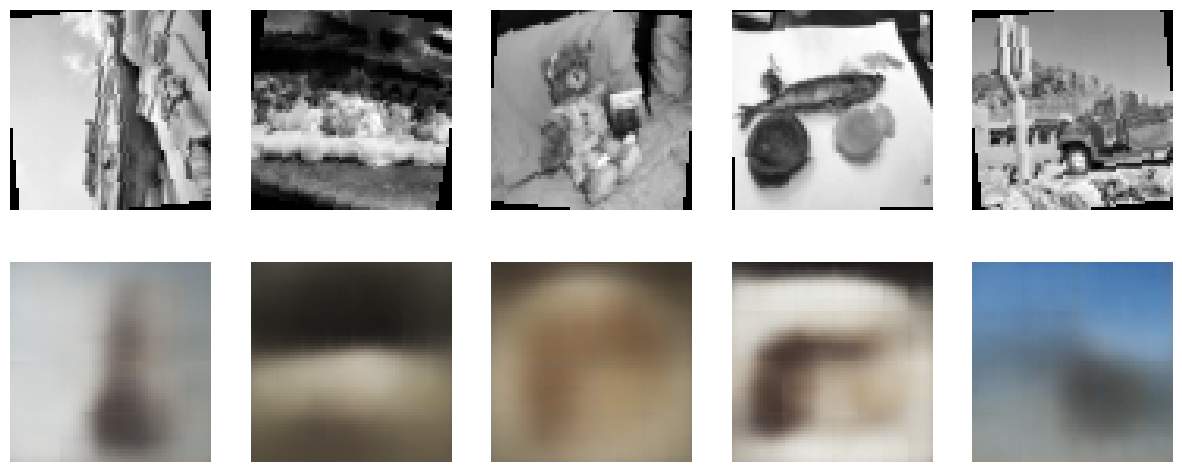

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.02it/s, loss=0.117]

Epoch: 28
	train_loss: 0.0985
	val_loss: 0.0986



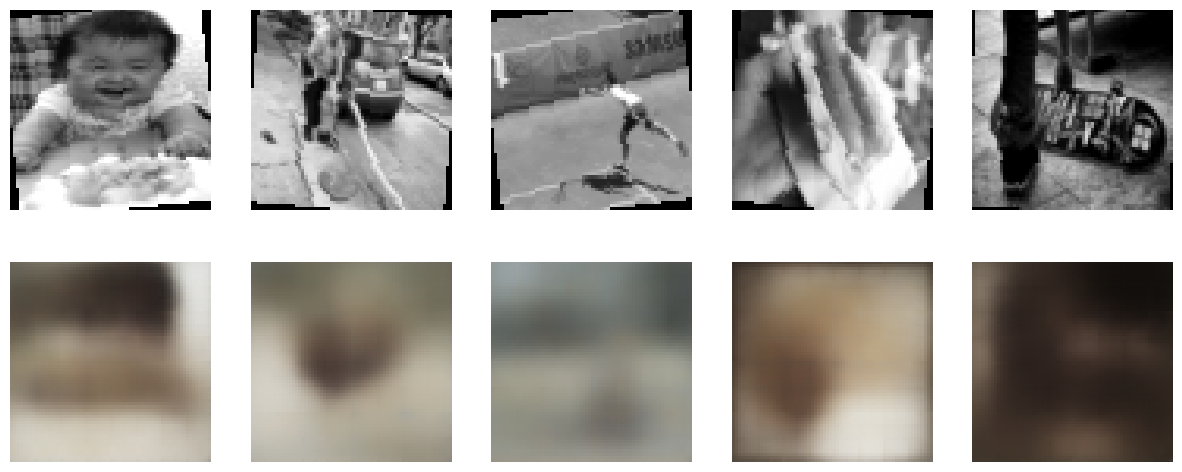

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.02it/s, loss=0.119]

Epoch: 29
	train_loss: 0.0985
	val_loss: 0.0985



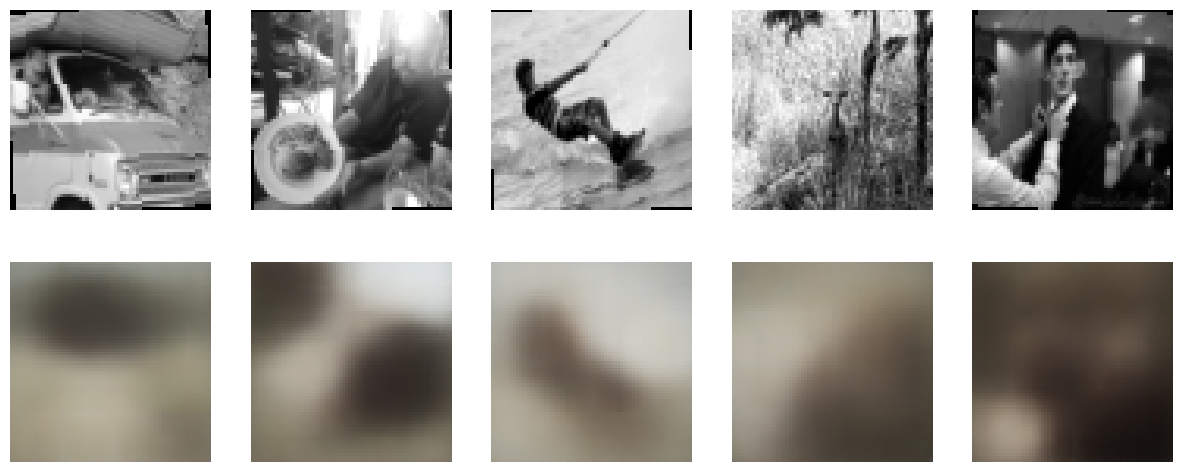

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.95it/s, loss=0.118]

Epoch: 30
	train_loss: 0.0983
	val_loss: 0.0984



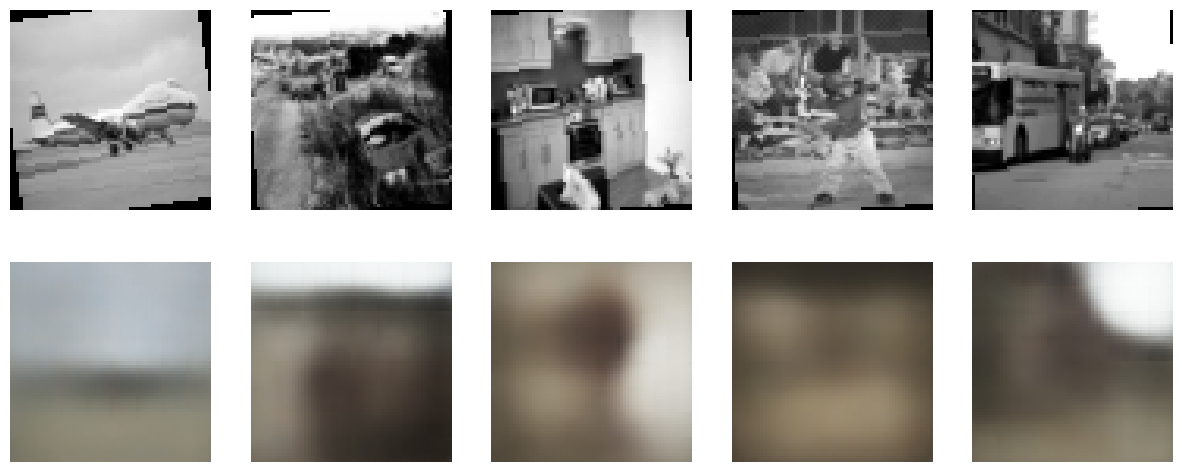

In [14]:
train_total_loss = []
val_total_loss = []

best_val_loss = float('inf')

for epoch in range(1, EPOCHS+1):
    train_loss = train_model(device, model, optimizer, loss_fn, train_loader)
    val_loss = evaluate_model(device, model, loss_fn, val_loader)
    scheduler.step(val_loss)
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    train_total_loss.append(train_loss.item())
    val_total_loss.append(val_loss.item())

    print(f"Epoch: {epoch}\n\ttrain_loss: {train_loss:.4f}\n\tval_loss: {val_loss:.4f}\n")

    if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss
            }, MODEL_PATH)
            print(f"Model saved with val loss {val_loss:.4f}.")

    model.eval()
    with torch.no_grad():
        x, y = next(iter(train_loader))
        x, y = x[:5].to(device), y[:5].to(device)
        outputs = model(x)
        show_gray_vs_rgb(x, outputs, n=5)
    model.train()

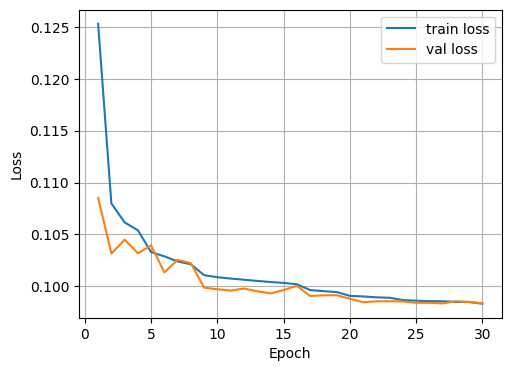

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, EPOCHS+1), train_total_loss, label='train loss')
plt.plot(range(1, EPOCHS+1), val_total_loss, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)